<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from catboost import CatBoostRegressor
import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore")

## Подготовка

In [2]:
try:
    data = pd.read_csv('C:/datasets/taxi.csv',index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])    
data.sort_index(inplace=True)
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [3]:
data.shape

(4416, 1)

<div class="alert alert-block alert-info">
<b>Комментарий:</b> Загрузили данные и выполнили ресемплирование по одному часу
</div>

## Анализ

In [4]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


<AxesSubplot:ylabel='num_orders'>

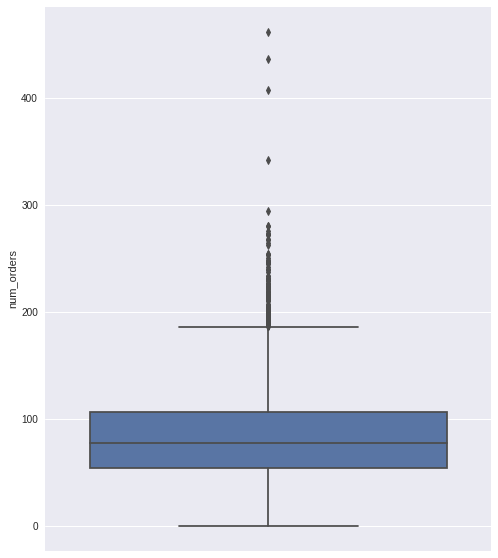

In [5]:
fig, ax = plt.subplots(figsize=(8,10))
sns.boxplot(y='num_orders',data=data)

<div class="alert alert-block alert-info">
<b>Комментарий:</b> Ящик с усами показывает некоторые выборсы, однако в них не ничего страшного, дальше мы убедимся по скользящему среднему и тренду, что это лишь рост заказов со временем.
</div>

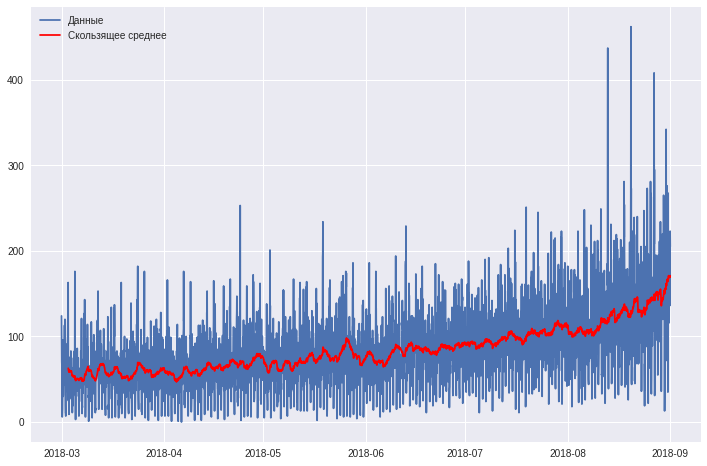

In [6]:
fig_1, ax1 = plt.subplots(figsize=(12,8))
ax1.plot(data['num_orders'])
ax1.plot(data['num_orders'].rolling(50).mean(), 'r')
ax1.legend(['Данные', 'Скользящее среднее'])

<div class="alert alert-block alert-info">
<b>Комментарий:</b> По графику с данными тяжело что либо сказать, а вот скользящее среднее говорит о росте заказов.
</div>

Text(0.5, 1.0, 'Seasonality Day')

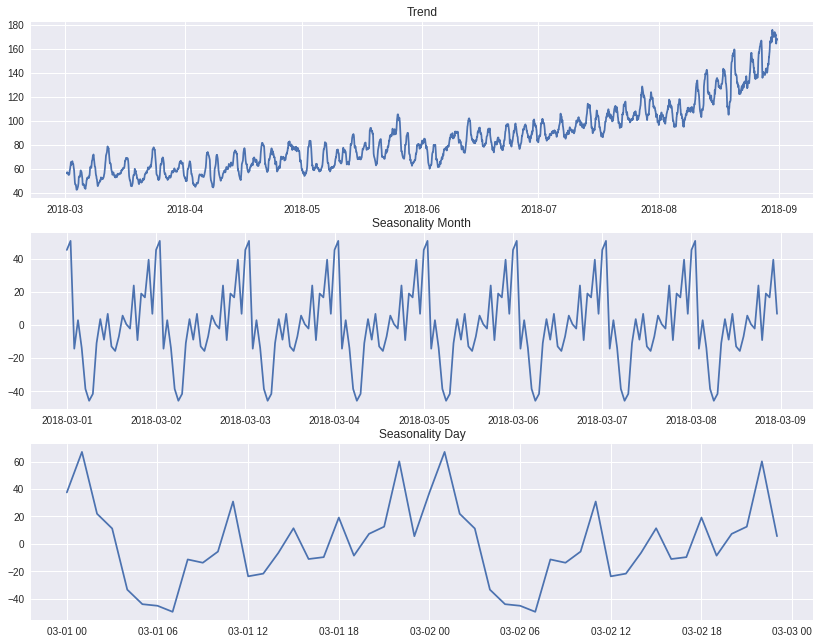

In [7]:
decomposed_all = seasonal_decompose(data)
decomposed_week = seasonal_decompose(data['2018-03-01':'2018-03-08'])
decomposed_day = seasonal_decompose(data['2018-03-01':'2018-03-02'])
fig_2, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(14,11))
ax1.plot(decomposed_all.trend)
ax1.set_title('Trend')
ax2.plot(decomposed_week.seasonal)
ax2.set_title('Seasonality Month')
ax3.plot(decomposed_day.seasonal)
ax3.set_title('Seasonality Day')

<div class="alert alert-block alert-info">
<b>Комментарий:</b> Рассмотрим тренд и сезонность. Тренд схож со скользящим средним, а вот сезонность, особенно если рассматривая для промежутка в 2 дня, говорит о том, что большое количество заказов приходится на полночь, падает до минимума к утру, и постепенно, колебательно, растет к вечеру.
</div>

## Обучение

In [8]:
def make_features(data, max_lag, rolling_mean_size, target_name):
    #data['year'] = data.index.year
    #data['month'] = data.index.month
    #data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data[target_name].shift(lag)

    data['rolling_mean'] = data[target_name].shift().rolling(rolling_mean_size).mean()

<div class="alert alert-block alert-info">
<b>Комментарий:</b> Принято решени не добавлять признаки года, так как он один для всей выборки.
</div>

<div class="alert alert-block alert-info">
<b>Комментарий:</b> Добавляются признаки дня недели и часа.
</div>

In [9]:
make_features(data, 1, 24, 'num_orders')
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train.dropna(inplace = True)

features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders'] 

features_test = test.drop('num_orders',axis=1)
target_test = test['num_orders'] 

print(train.shape, features_train.shape, target_train.shape)
print(test.shape, features_test.shape, target_test.shape)

(3950, 5) (3950, 4) (3950,)
(442, 5) (442, 4) (442,)


<div class="alert alert-block alert-info">
<b>Комментарий:</b> max_lag = 1, rolling_mean_size = 24
</div>

In [10]:
%%time
tscv = TimeSeriesSplit(n_splits=8)
model_linear = LinearRegression()
result_linear = cross_val_score(model_linear, features_train, target_train, 
                                    scoring = 'neg_root_mean_squared_error', cv=tscv, n_jobs = -1)
print("LinearRegression RMSE:", abs(result_linear).mean())

LinearRegression RMSE: 31.366763577025022
CPU times: user 35.2 ms, sys: 993 µs, total: 36.2 ms
Wall time: 34.9 ms


In [11]:
%%time
CBR = CatBoostRegressor(random_state=12345, verbose = False, loss_function ='RMSE')
parameters_CBR = {'depth': [4,5,6,7],
                  'learning_rate': [0.03,0.1],
                  'iterations': [10, 20,30,40]}
grid_CBR = GridSearchCV(CBR, param_grid = parameters_CBR, 
                        cv=tscv, scoring = "neg_root_mean_squared_error", n_jobs=-1)
grid_CBR.fit(features_train, target_train)
print("CatBoost GridCV RMSE:", grid_CBR.best_score_*(-1))
print("Параметры модели CatBoostRegressor:", grid_CBR.best_params_)

CatBoost GridCV RMSE: 25.866315669107152
Параметры модели CatBoostRegressor: {'depth': 7, 'iterations': 40, 'learning_rate': 0.1}
CPU times: user 6.21 s, sys: 823 ms, total: 7.03 s
Wall time: 1min 43s


In [12]:
%%time
lgb_model = lgb.LGBMRegressor(metric = 'rmse', random_state=12345)
result_lgb = cross_val_score(lgb_model, features_train, target_train, 
                                  scoring = "neg_mean_squared_error", cv=tscv, n_jobs = -1)
print("LGBMRegressor RMSE:", (abs(result_lgb)**0.5).mean())

LGBMRegressor RMSE: 24.85256040439829
CPU times: user 14.1 s, sys: 38.3 ms, total: 14.1 s
Wall time: 14.1 s


## Тестирование

<div class="alert alert-block alert-info">
<b>Комментарий:</b> Выберем LGBMRegressor в качестве лучшей модели.
</div>

In [13]:
lgb_model.fit(features_train,target_train)
predict_lgb = lgb_model.predict(features_test)
print('RMSE на тестовой выборке:', mean_squared_error(target_test, predict_lgb)**0.5)

RMSE на тестовой выборке: 43.39079269785423


Text(0.5, 1.0, '2018-08-26 -- 2018-08-28')

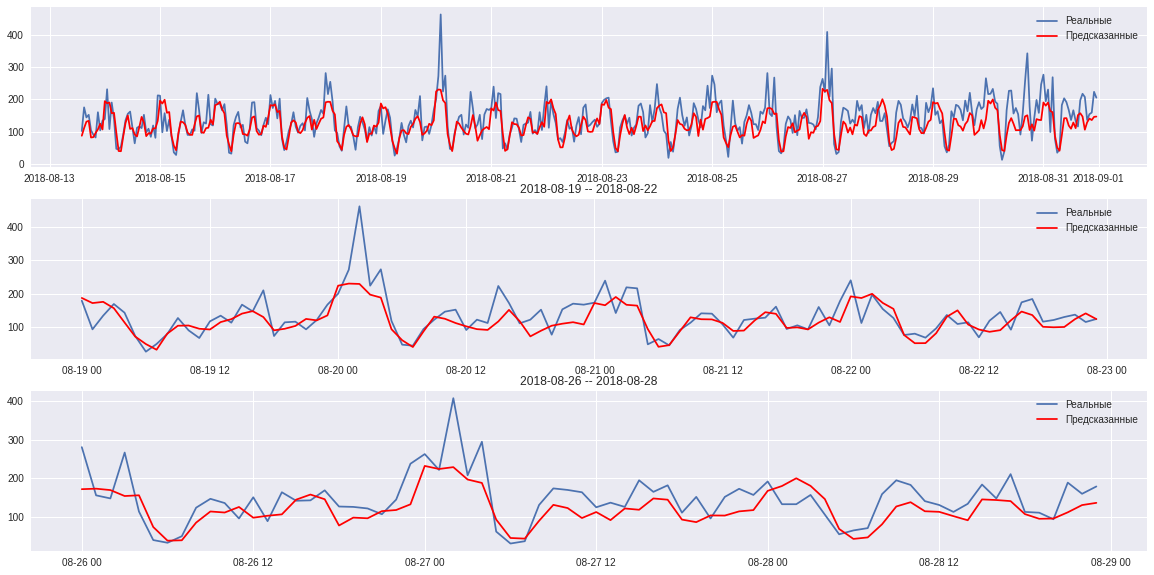

In [14]:
fig_3, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(20,10))
ax1.plot(target_test)
ax1.plot(pd.Series(data=predict_lgb, index= target_test.index), 'r')
ax1.legend(['Реальные', 'Предсказанные'])

ax2.plot(target_test['2018-08-19':'2018-08-22'])
ax2.plot(pd.Series(data=predict_lgb, index= target_test.index)['2018-08-19':'2018-08-22'], 'r')
ax2.legend(['Реальные', 'Предсказанные'])
ax2.set_title('2018-08-19 -- 2018-08-22')

ax3.plot(target_test['2018-08-26':'2018-08-28'])
ax3.plot(pd.Series(data=predict_lgb, index= target_test.index)['2018-08-26':'2018-08-28'], 'r')
ax3.legend(['Реальные', 'Предсказанные'])
ax3.set_title('2018-08-26 -- 2018-08-28')

<div class="alert alert-block alert-info">
<b>Комментарий:</b> Вывел графики. Предсказанные значения имеют общую тенденцию и очень напоминаю тренд или скользящее среднее. При рассмотрении определенных дней (ax2, ax3) видно, что некоторые возвышения он не предсказывает, видимо поскольку это могут быть праздники, а данных за несколько лет мы не имеем, чтобы модель обучалась соответствующе.
</div>

## Вывод

Успех, были выполнены поставленные задачи ввиде обучения и нахождения модели, которая показала результат меньше 48 на тестовой выборке. Все благодаря созданию признаков из данных о дате, кроме того, важным является подбор дополнительных признаков ввиде отстающих значений и скользящего среднего, сильнее всего влияют как раз отстающие значения. Можно было бы сделать больше чем 50 столбцов отстающих значений, но тогда нам пришлось бы отказаться от части данных, что плохо, оптимально было установлено имеено значение 50, дальше рост RMSE не слишком велик.

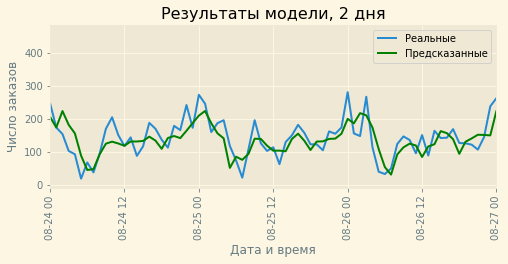